In [1]:
## Librerias a importar

import requests
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values

In [44]:
## Conexion a API

url = 'https://rickandmortyapi.com/api/character'
headers = {"Accept-Encoding": "gzip, deflate"}

response = requests.get(url, headers = headers)
data = response.json()

df = pd.json_normalize(data['results'], sep='_')

while data['info']['next']:
    response = requests.get(data['info']['next'], headers = headers)
    data = response.json()

    df2 = pd.json_normalize(data['results'], sep='_')
    df = pd.concat([df, df2], ignore_index=True)

df = df.drop(['episode'], axis=1)
df.head(1)

,id,name,status,species,type,gender,image,url,created,origin_name,origin_url,location_name,location_url
0,1,Rick Sanchez,Alive,Human,,Male,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/1,2017-11-04T18:48:46.250Z,Earth (C-137),https://rickandmortyapi.com/api/location/1,Citadel of Ricks,https://rickandmortyapi.com/api/location/3


In [3]:
## Conexion a DB Redshift usando psycopg2

url = "data-engineer-cluster.cyhh5bfevlmn.us-east-1.redshift.amazonaws.com"
data_base = "data-engineer-database"
user = "federicohernansanches_coderhouse"
pwd = "6H0Tll7uih"

try:
    conn = psycopg2.connect(
        host = url,
        dbname = data_base,
        user = user,
        password = pwd,
        port = '5439'
    )
    cur = conn.cursor()
    print("Connected to Redshift successfully!")
    
except Exception as e:
    print("Unable to connect to Redshift.")
    print(e)

Connected to Redshift successfully!


In [4]:
## Creacion de la tabla destino

table_name = 'federicohernansanches_coderhouse.characters'
type_map = {'int64': 'INT', 'object': 'VARCHAR(255)'}

# Check df nombre de columnas y tipo de dato
dtypes = df.dtypes
cols = list(dtypes.index)
tipos = list(dtypes.values)

# Mapeo los tipos de datos del df a tipo de datos aceptados por sql y creo lista para iterar con los nombres + tipos
sql_dtypes = [type_map[str(dtype)] for dtype in tipos]
column_defs = [f"{name} {data_type}" for name, data_type in zip(cols, sql_dtypes)]

# String de creacion
table_schema = f"""CREATE TABLE IF NOT EXISTS {table_name} ({', '.join(column_defs)});"""

# Ejecucion sql script
cur.execute(table_schema)

In [5]:
## Insercion de datos

insert_sql = f"INSERT INTO {table_name} ({', '.join(cols)}) VALUES %s"
values = [tuple(x) for x in df.to_numpy()]

cur.execute("BEGIN")
execute_values(cur, insert_sql, values)
cur.execute("COMMIT")

In [6]:
## Persisto cambios en la conexion a la base y cierro la misma

cur.close()
conn.close()
print('Proceso terminado')

Proceso terminado


<Axes: title={'center': 'Characters Origin'}, xlabel='Origen', ylabel='# Characters'>

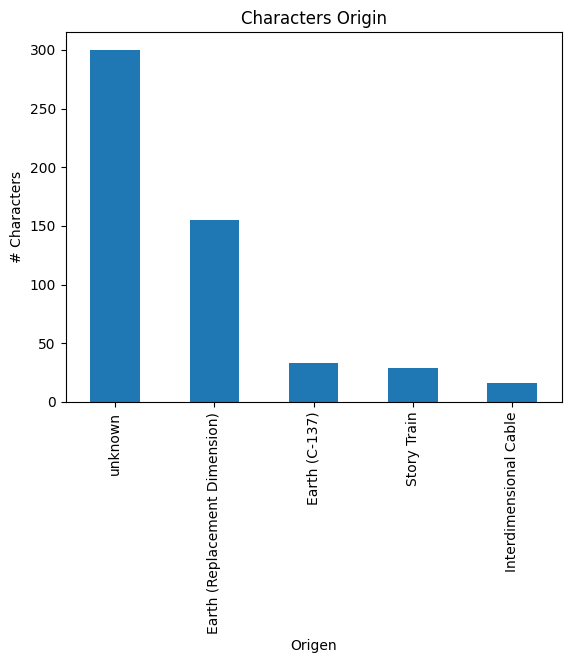

In [23]:
## Chart para ver los 5 Origenes con mas Personajes

df2 = df.groupby('origin_name')['origin_name'].count().sort_values(ascending=False).head(5)
df2.plot(kind='bar', xlabel='Origen', ylabel='# Characters', title='Characters Origin')

<Axes: xlabel='species'>

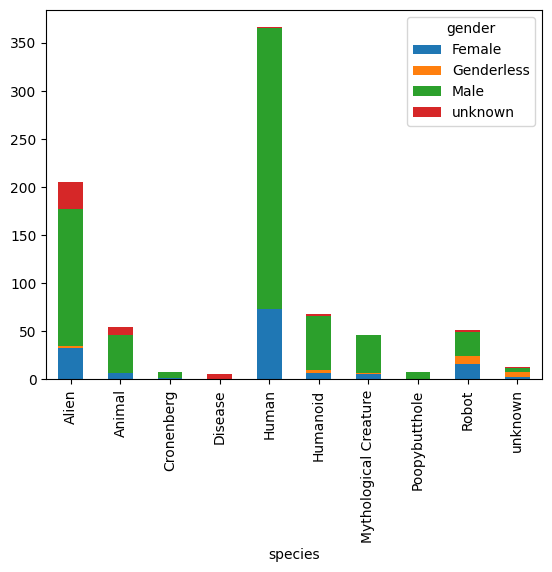

In [60]:
## Chart para ver como se distrubuyen los sexos por especie

df.groupby(['species', 'gender']).size().unstack().plot(kind='bar', stacked=True)